* Student: Anastasia Rogowiecki / Роговецкая Анастасия
* Stepik: Анастасия_Роговецкая_221933185
* Kaggle: Ericka42

# Импортируем необходимые библиотеки

In [112]:
import pickle
import numpy as np
import pandas as pd
from skimage import io
import math

import torch.cuda

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import datasets, transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import WeightedRandomSampler
import torch.nn as nn
import torch.nn.functional as func

from matplotlib import colors, pyplot as plt
import seaborn as sns
%matplotlib inline

import random

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

Если CUDA доступна, код перемещает модель и данные на GPU для более быстрого обучения. Если CUDA недоступна, код использует CPU.







In [113]:
train_on_gpu = torch.cuda.is_available()
DEVICE = torch.device("cpu")

if not train_on_gpu:
    print('CUDA не доступна. Обучение проходит на CPU')
else:
    DEVICE = torch.device("cuda")
    print('CUDA доступна. Обучение проходит на GPU')

CUDA доступна. Обучение проходит на GPU


In [114]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [115]:
RESCALE_SIZE = 224

In [116]:
#!kaggle competitions download -c journey-springfield
#!cp -r "../input/journey-springfield" "./"

# Разделение датасета

Теперь создадим переменные, содержащие пути до папок train/test

In [117]:
test_path = Path('../input/journey-springfield/testset/testset')
train_path = Path('../input/journey-springfield/train/simpsons_dataset')

Отсортируем файлы и дадим класс (имя) каждому изображению из теста

In [118]:
train_val_files = sorted(list(train_path.rglob('*.jpg')))
train_val_labels = [i.parent.name for i in train_val_files]

In [119]:
test_val_files = sorted(list(test_path.rglob('*.jpg')))
test_val_labels = [i.parent.name for i in test_val_files]

# Анализ данных

Рассмотрим на распределение классов для понимания сбалансированные ли они

In [120]:
df = pd.DataFrame(train_val_labels, columns=['name'])
df['count'] = 1
df = df.groupby('name').count().sort_values('count')

 Выведем случайные строки

In [121]:
df.sample(n=7)

,count
name,
mayor_quimby,246
cletus_spuckler,47
homer_simpson,2246
fat_tony,27
otto_mann,32
nelson_muntz,358
barney_gumble,106


Выведем график распределение классов

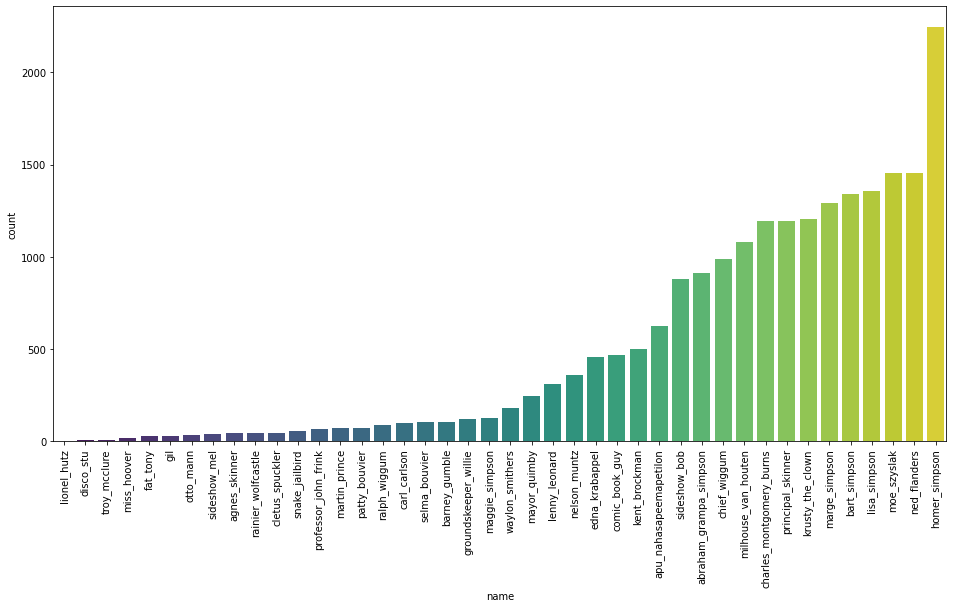

In [122]:
plt.figure(figsize=(16, 8))
sns.barplot(x= df.index, y='count', data=df, palette='viridis')
plt.xticks(rotation=90)
plt.show()

Теперь в виде таблицы

In [123]:
data = pd.Series(train_val_labels).value_counts().to_frame('count')
data

,count
homer_simpson,2246
ned_flanders,1454
moe_szyslak,1452
lisa_simpson,1354
bart_simpson,1342
marge_simpson,1291
krusty_the_clown,1206
principal_skinner,1194
charles_montgomery_burns,1193
milhouse_van_houten,1079


Классы не сбалансированные

Посмотрим на произвольные 10 фотографий из датасета

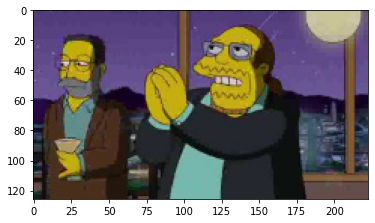

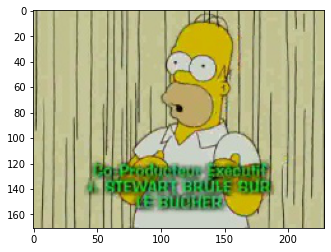

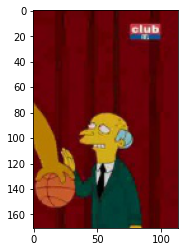

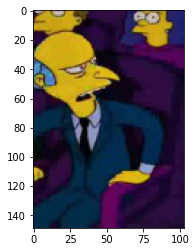

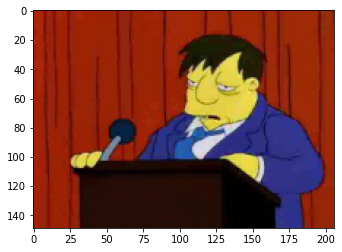

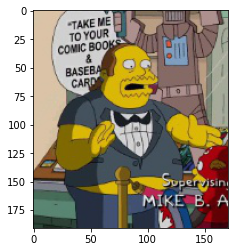

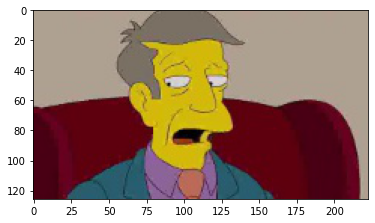

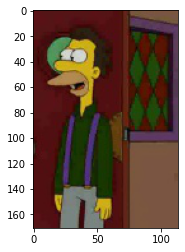

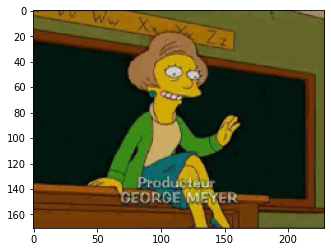

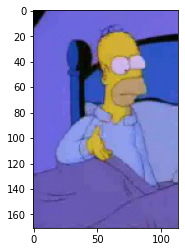

In [124]:
random_test_images = random.sample(test_val_files, 10)

for img_path in random_test_images:
    img = Image.open(img_path)
    plt.imshow(img)
    plt.show()

# Подготовка данных
<br>
Улучшим ситуацию с дисбалансом классов с помощью аугментации изображений, допустим в каждом классе у нас не менее 2500 изображений

In [125]:
data['to_add'] = data['count'].apply(lambda x: 2500 - x if x < 2500 else 0)
data['one_iteration'] = data.apply(lambda x: math.ceil(x['to_add'] / x['count']), axis=1)
data

,count,to_add,one_iteration
homer_simpson,2246,254,1
ned_flanders,1454,1046,1
moe_szyslak,1452,1048,1
lisa_simpson,1354,1146,1
bart_simpson,1342,1158,1
marge_simpson,1291,1209,1
krusty_the_clown,1206,1294,2
principal_skinner,1194,1306,2
charles_montgomery_burns,1193,1307,2
milhouse_van_houten,1079,1421,2


Столбец one_iteration покажет нам, сколько новых изображений мы должны сделать из одного исходного изображения.

# Аугментация

In [126]:
from torchvision import transforms

augmenters = {
    'Crop': transforms.Compose([
        transforms.Resize(size=224),
        transforms.RandomCrop(174)
    ]),
    'Rotation': transforms.RandomRotation(degrees=(-25, 25)),
    'HFlip': transforms.RandomHorizontalFlip(p=1),
    'Perspective': transforms.RandomPerspective(distortion_scale=0.6, p=1.0),
    'ColorJitter': transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
    'RandomResizedCrop': transforms.RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.333)),
    'RandomVerticalFlip': transforms.RandomVerticalFlip(p=1),
    'RandomGrayscale': transforms.RandomGrayscale(p=0.1),
    'RandomRotation90': transforms.RandomRotation(degrees=(0, 90)),
    'RandomAffine': transforms.RandomAffine(degrees=(-30, 30), translate=(0.2, 0.2), scale=(0.8, 1.2)),
    'RandomErasing': transforms.RandomErasing(p=0.5, scale=(0.02, 0.2), ratio=(0.3, 3.3), value='random'),
    'GaussianBlur': transforms.GaussianBlur(kernel_size=3)
}

In [127]:
def load_image(file):
    image = Image.open(file)
    image.load()
    return image

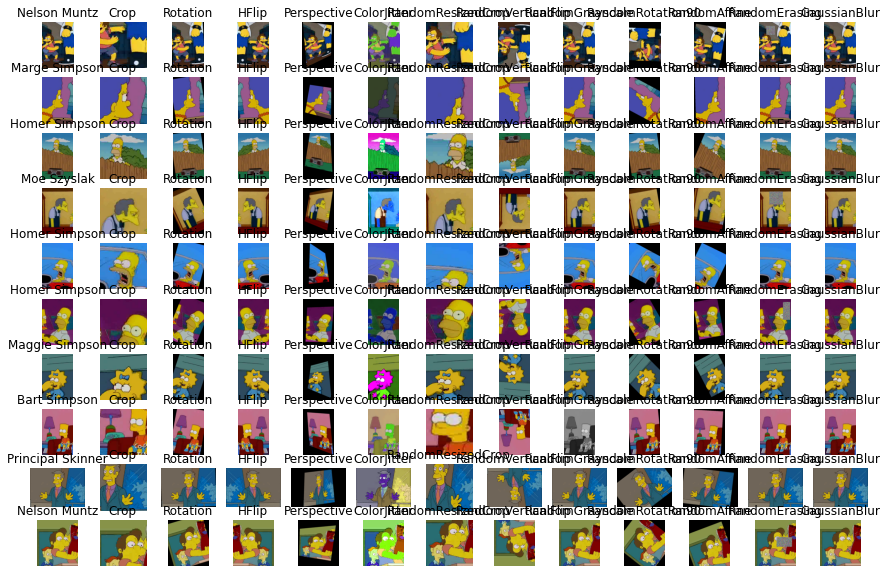

In [130]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
from torchvision import transforms

def load_image(file_path):
    return Image.open(file_path).convert("RGB")

n_examples = 10  

fig, ax = plt.subplots(nrows=n_examples, ncols=(len(augmenters) + 1), figsize=(15, 10))

for i in range(n_examples):
    random_character = int(np.random.uniform(0, len(train_val_files)))  
    img_orig = load_image(train_val_files[random_character])  
    img_label = train_val_files[random_character].parent.name  

    img_label = " ".join(map(lambda x: x.capitalize(), img_label.split('_')))  
    ax[i][0].imshow(img_orig)
    ax[i][0].set_title(img_label)
    ax[i][0].axis('off')

    for j, (augmenter_name, augmenter) in enumerate(augmenters.items()):
        img_orig_tensor = transforms.ToTensor()(img_orig)  
        img_aug_tensor = augmenter(img_orig_tensor)
        img_aug = transforms.ToPILImage()(img_aug_tensor)  
        ax[i][j + 1].imshow(img_aug)
        ax[i][j + 1].set_title(augmenter_name)
        ax[i][j + 1].axis('off')

plt.show()


Применим аугментацию для изображений и сохраним результаты в папке train

In [131]:
augmentations = transforms.RandomChoice([
    transforms.Compose([
        transforms.Resize(size=224),
        transforms.CenterCrop(size=224),
        transforms.RandomCrop(224)
    ]),
    transforms.RandomRotation(degrees=(-25, 25)),
    transforms.RandomHorizontalFlip(p=1),
])
train_transforms = transforms.Compose([
    augmentations,
    transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
    transforms.Lambda(lambda x: np.array(x, dtype="float32") / 255),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) ,
])
train_dataset = datasets.ImageFolder(root=train_path, transform=train_transforms)

Рассчитаем веса для классов. Менее популярный класс будет иметь меньший вес.

In [132]:
from collections import Counter

class_count = Counter(train_dataset.targets)
class_weights = {i: 1/c for i, c in class_count.items()}
sample_weights = [0] * len(train_dataset)
for i, (data, label) in enumerate(tqdm(train_dataset)):
    class_weight = class_weights[label]
    sample_weights[i] = class_weight
    
N = max(class_count.values()) * len(class_count)  # fit to max
train_sampler = WeightedRandomSampler(sample_weights, num_samples=N, replacement=True)
train_loader = DataLoader(train_dataset, batch_size=256, sampler=train_sampler, num_workers=2)

100%|██████████| 20933/20933 [02:10<00:00, 160.63it/s]


Посмотрим теперь на распределение классов

In [133]:
count = Counter()
for data, labels in tqdm(train_loader):
    count += Counter(labels.tolist())
print(sum(count.values()), count)

100%|██████████| 369/369 [05:32<00:00,  1.11it/s]

94332 Counter({13: 2388, 25: 2326, 17: 2309, 38: 2300, 24: 2296, 22: 2292, 11: 2290, 16: 2290, 7: 2290, 1: 2282, 4: 2280, 14: 2273, 19: 2262, 30: 2260, 18: 2260, 32: 2258, 5: 2257, 6: 2257, 28: 2255, 23: 2249, 36: 2243, 26: 2242, 20: 2242, 10: 2241, 8: 2239, 12: 2239, 27: 2237, 31: 2230, 40: 2222, 34: 2222, 33: 2219, 39: 2215, 9: 2207, 0: 2206, 37: 2200, 15: 2198, 41: 2196, 3: 2194, 21: 2193, 2: 2185, 35: 2159, 29: 2129})


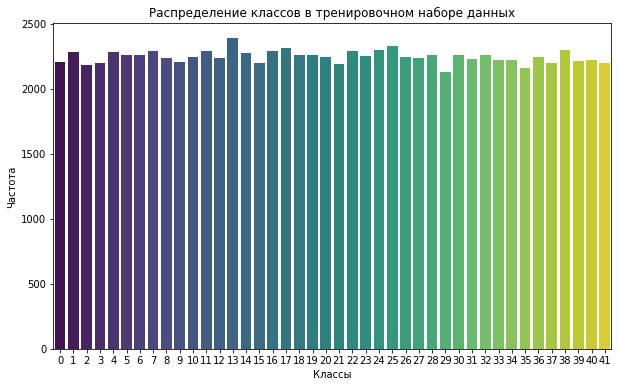

In [134]:
labels, frequencies = zip(*count.items())

frequencies = list(map(int, frequencies))

data = pd.DataFrame({'Классы': labels, 'Частота': frequencies})

plt.figure(figsize=(10, 6))
sns.barplot(x='Классы', y='Частота', data=data, palette='viridis')
plt.xlabel('Классы')
plt.ylabel('Частота')
plt.title('Распределение классов в тренировочном наборе данных')
plt.show()

Как мы видим, нам удолось улучшить ситуацию с несбалансированными данными

# Построение нейросети

In [135]:
def fit_epoch(model, train_loader, criterion, optimizer, scheduler):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = func.softmax(outputs, dim=-1).argmax(-1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    scheduler.step()
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [136]:
def train(model, loss, optimizer, scheduler, epochs, batch_size):
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} train_acc {t_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, loss, optimizer, scheduler)
            history.append((train_loss, train_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss, t_acc=train_acc))

    return history

In [137]:
n_classes = len(np.unique(train_val_labels))
model = nn.Sequential(
    nn.Sequential(
        nn.Conv2d(3, 8, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
    ),
    nn.Sequential(
        nn.Conv2d(8, 16, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
    ),
    nn.Sequential(
        nn.Conv2d(16, 32, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
    ),
    nn.Sequential(
        nn.Conv2d(32, 64, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
    ),
    nn.Sequential(
        nn.Conv2d(64, 96, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
    ),
    nn.Flatten(),
    nn.Sequential(
    nn.Linear(in_features=2400, out_features=4096, bias=True),
    nn.Dropout(p=0.1),
    nn.ReLU(inplace=True),
    ),
    nn.Sequential(
    nn.Linear(in_features=4096, out_features=4096, bias=True),
    nn.Dropout(p=0.1),
    nn.ReLU(inplace=True),
    ),
    nn.Linear(in_features=4096, out_features=n_classes, bias=True),
    nn.Dropout(p=0.2),
).to(DEVICE)
print("We will classify {} classes".format(n_classes))
print(f"Model: {model}")

We will classify 42 classes
Model: Sequential(
  (0): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (4): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (5): Flatten(start_dim=1, end_dim=-1)
  (6):

In [138]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), amsgrad=True, lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [140]:
history = train(model=model, loss=loss, optimizer=optimizer, scheduler=scheduler, epochs=20, batch_size=256)

epoch:   5%|▌         | 1/20 [05:49<1:50:37, 349.34s/it]


Epoch 001 train_loss: 1.8860 train_acc 0.4912


epoch:  10%|█         | 2/20 [11:41<1:45:20, 351.16s/it]


Epoch 002 train_loss: 0.9296 train_acc 0.7179


epoch:  15%|█▌        | 3/20 [17:33<1:39:37, 351.63s/it]


Epoch 003 train_loss: 0.7244 train_acc 0.7632


epoch:  20%|██        | 4/20 [23:26<1:33:54, 352.14s/it]


Epoch 004 train_loss: 0.6434 train_acc 0.7799


epoch:  25%|██▌       | 5/20 [29:25<1:28:35, 354.36s/it]


Epoch 005 train_loss: 0.5931 train_acc 0.7915


epoch:  30%|███       | 6/20 [35:16<1:22:26, 353.32s/it]


Epoch 006 train_loss: 0.5616 train_acc 0.7977


epoch:  35%|███▌      | 7/20 [41:07<1:16:22, 352.48s/it]


Epoch 007 train_loss: 0.5404 train_acc 0.8026


epoch:  40%|████      | 8/20 [46:58<1:10:24, 352.03s/it]


Epoch 008 train_loss: 0.5010 train_acc 0.8093


epoch:  45%|████▌     | 9/20 [52:53<1:04:44, 353.15s/it]


Epoch 009 train_loss: 0.4750 train_acc 0.8164


epoch:  50%|█████     | 10/20 [58:50<59:00, 354.09s/it] 


Epoch 010 train_loss: 0.4715 train_acc 0.8170


epoch:  55%|█████▌    | 11/20 [1:04:47<53:17, 355.24s/it]


Epoch 011 train_loss: 0.4657 train_acc 0.8174


epoch:  60%|██████    | 12/20 [1:10:44<47:25, 355.72s/it]


Epoch 012 train_loss: 0.4654 train_acc 0.8183


epoch:  65%|██████▌   | 13/20 [1:16:42<41:34, 356.41s/it]


Epoch 013 train_loss: 0.4623 train_acc 0.8184


epoch:  70%|███████   | 14/20 [1:22:41<35:42, 357.17s/it]


Epoch 014 train_loss: 0.4574 train_acc 0.8196


epoch:  75%|███████▌  | 15/20 [1:28:37<29:43, 356.63s/it]


Epoch 015 train_loss: 0.4597 train_acc 0.8181


epoch:  80%|████████  | 16/20 [1:34:35<23:49, 357.27s/it]


Epoch 016 train_loss: 0.4534 train_acc 0.8212


epoch:  85%|████████▌ | 17/20 [1:40:29<17:48, 356.08s/it]


Epoch 017 train_loss: 0.4486 train_acc 0.8228


epoch:  90%|█████████ | 18/20 [1:46:23<11:51, 355.54s/it]


Epoch 018 train_loss: 0.4511 train_acc 0.8218


epoch:  95%|█████████▌| 19/20 [1:52:19<05:55, 355.64s/it]


Epoch 019 train_loss: 0.4553 train_acc 0.8197


epoch: 100%|██████████| 20/20 [1:58:11<00:00, 354.59s/it]


Epoch 020 train_loss: 0.4536 train_acc 0.8198


In [141]:
loss, acc = zip(*history)

Посмотрим на график лосс-функции

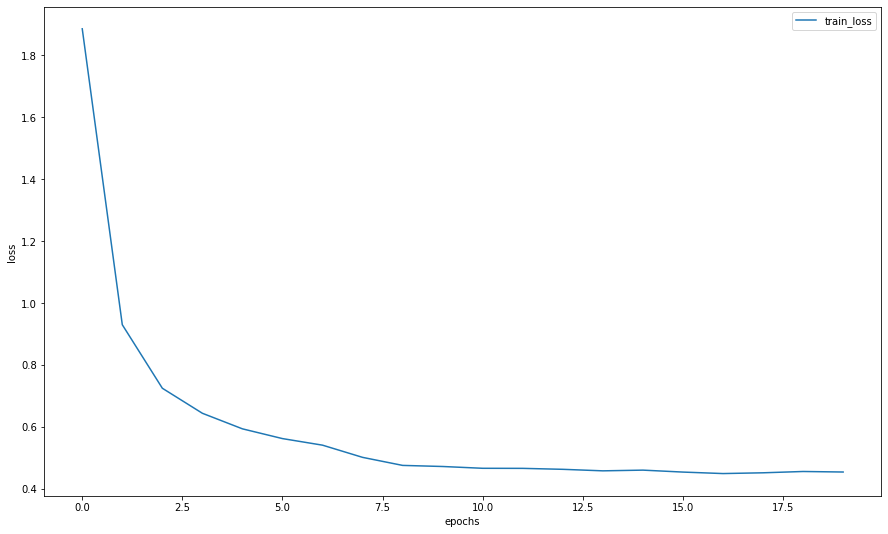

In [142]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [143]:
class TestDataset(Dataset):
    def __init__(self, files):
        self.files = files

    def __getitem__(self, index):
        test_transforms = transforms.Compose([
            transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
            transforms.Lambda(lambda x: np.array(x, dtype="float32") / 255),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) ,
        ])
        img = Image.open(self.files[index]).convert('RGB')
        return test_transforms(img)
    
    def __len__(self):
        return len(self.files)

In [144]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = func.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [145]:
test_dataset = TestDataset(test_val_files)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=256)
probs = predict(model, test_loader)
preds = [train_dataset.classes[i] for i in probs.argmax(axis=-1)]
test_filenames = [path.name for path in test_dataset.files]

# BaseLine Score и сохранение результатов

In [146]:
my_submit = pd.DataFrame({
    "Id": test_filenames,
    "Expected": preds
})

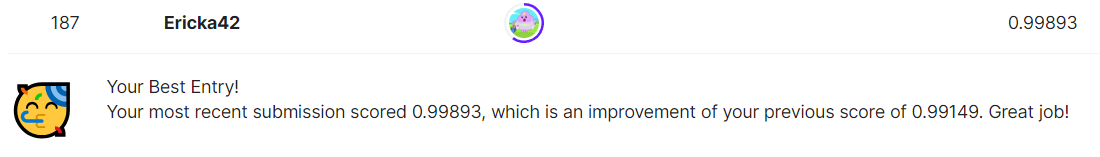

In [147]:
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [148]:
my_submit.to_csv("submission.csv", index=False)